In [38]:
#!pip install scikit-bio
import pandas as pd
import numpy as np
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.patches import Ellipse
from scipy.stats import chi2
from sklearn.manifold import MDS
from sklearn.metrics import pairwise_distances
from sklearn.preprocessing import StandardScaler
from scipy.spatial.distance import pdist, squareform
from skbio.stats.composition import clr
from sklearn.preprocessing import MinMaxScaler
from scipy.spatial.distance import braycurtis
from sklearn.manifold import MDS
from functools import reduce

## Load, Explore and prepare the 16s rRNA data 

In [40]:
df = pd.read_csv("16S rRNA.csv")  

In [41]:
df.head()

,sample-id,Patient,Timepoint,c__Gammaproteobacteria;o__Enterobacterales;f__Enterobacteriaceae;g__Escherichia-Shigella,c__Bacteroidia;o__Bacteroidales;f__Bacteroidaceae;g__Bacteroides,c__Gammaproteobacteria;o__Enterobacterales;f__Enterobacteriaceae;__,c__Gammaproteobacteria;o__Burkholderiales;f__Burkholderiaceae;g__Ralstonia,c__Gammaproteobacteria;o__Burkholderiales;f__Comamonadaceae;__,c__Clostridia;o__Oscillospirales;f__Ruminococcaceae;g__Faecalibacterium,c__Alphaproteobacteria;o__Rhizobiales;f__Xanthobacteraceae;g__Afipia,...,c__Desulfovibrionia;o__Desulfovibrionales;f__Desulfovibrionaceae;g__uncultured,c__Clostridia;o__Oscillospirales;f__UCG-010;g__UCG-010,c__Clostridia;o__Peptostreptococcales-Tissierellales;f__Peptostreptococcales-Tissierellales;g__Ezakiella,Unassigned.1,c__Clostridia;o__Peptostreptococcales-Tissierellales;f__Peptostreptococcales-Tissierellales;g__Finegoldia,c__Clostridia;o__Peptostreptococcales-Tissierellales;f__Anaerovoracaceae;g__Family_XIII_UCG-001,c__Alphaproteobacteria;o__Caulobacterales;f__Caulobacteraceae;g__uncultured,Patient.1,Timepoint.1,Fcal
0,1A,1,Baseline,53,11534,0,0,0,3444,0,...,0,0,0,6,0,0,0,1,Baseline,608
1,2A,2,Baseline,0,28833,3567,0,0,0,0,...,0,0,0,0,0,0,0,2,Baseline,912
2,3A,3,Baseline,6374,63481,0,0,0,12282,0,...,0,0,0,0,0,3,0,3,Baseline,2200
3,4A,4,Baseline,422,22733,0,0,0,5105,0,...,0,11,0,0,0,0,0,4,Baseline,2000
4,5A,5,Baseline,19765,18741,1181,0,0,17427,0,...,0,0,0,0,0,0,0,5,Baseline,182


In [42]:
# Step 1: Identify taxonomic columns 
taxa_columns = df.columns[3:-3]  

# Step 2: Extract genus names from column headers
def extract_genus(col):
    for part in col.split(';'):
        if part.startswith("g__"):
            genus_name = part.replace("g__", "") or "Unassigned"
            return "g__" + genus_name
    return "g__Unassigned"

genus_names = [extract_genus(col) for col in taxa_columns]

# Step 3: Subset the DataFrame using valid column names
df_genus = df[taxa_columns].copy()
df_genus.columns = genus_names

# Step 4: Collapse by genus (sum duplicate genus names)
df_genus_grouped = df_genus.groupby(df_genus.columns, axis=1).sum()

#  Add sample ID as index
df_genus_grouped.index = df["sample-id"]

# inspect the result
df_genus_grouped.to_csv("collapsed_genus_level.csv")
print(df_genus_grouped.head())

           g__Acidaminococcus  g__Acidibacter  g__Acinetobacter  \
sample-id                                                         
1A                          0               0                 0   
2A                          0               0                 0   
3A                          0               0                 0   
4A                          0               0                 0   
5A                          0               0                 0   

           g__Actinobacillus  g__Actinomyces  g__Afipia  g__Agathobacter  \
sample-id                                                                  
1A                         0               0          0             1174   
2A                         0               0          0                0   
3A                         0               0          0                0   
4A                         0               0          0              750   
5A                         0              19          0             2814  

/var/folders/0_/qg07x0dd5s5dkp59h7mxv64h0000gn/T/ipykernel_9897/922687950.py:19: FutureWarning: DataFrame.groupby with axis=1 is deprecated. Do `frame.T.groupby(...)` without axis instead.
  df_genus_grouped = df_genus.groupby(df_genus.columns, axis=1).sum()


In [47]:
#cleaning 
df_genus_clean = df_genus_grouped.copy()

# Remove the 'g__' prefix from all column names
df_genus_clean.columns = df_genus_clean.columns.str.replace("g__", "", regex=False)

# Preview the cleaned column names
print(df_genus_clean.columns.tolist()[:10])

['Acidaminococcus', 'Acidibacter', 'Acinetobacter', 'Actinobacillus', 'Actinomyces', 'Afipia', 'Agathobacter', 'Akkermansia', 'Alistipes', 'Alloprevotella']


In [49]:
df_genus_clean.head()

,Acidaminococcus,Acidibacter,Acinetobacter,Actinobacillus,Actinomyces,Afipia,Agathobacter,Akkermansia,Alistipes,Alloprevotella,...,[Eubacterium]_eligens_group,[Eubacterium]_fissicatena_group,[Eubacterium]_hallii_group,[Eubacterium]_siraeum_group,[Eubacterium]_ventriosum_group,[Eubacterium]_xylanophilum_group,[Ruminococcus]_gauvreauii_group,[Ruminococcus]_gnavus_group,[Ruminococcus]_torques_group,uncultured
sample-id,,,,,,,,,,,,,,,,,,,,,
1A,0,0,0,0,0,0,1174,0,7508,0,...,148,0,0,6,29,0,0,611,0,2448
2A,0,0,0,0,0,0,0,0,121,0,...,0,0,67,0,25,0,0,134,0,0
3A,0,0,0,0,0,0,0,674,93,0,...,0,0,40,0,46,0,0,2330,1196,748
4A,0,0,0,0,0,0,750,129,835,70,...,9,0,77,13,0,0,94,0,116,0
5A,0,0,0,0,19,0,2814,0,263,0,...,129,0,1175,36,28,0,333,91,919,312


In [51]:
df_genus_clean.describe()

,Acidaminococcus,Acidibacter,Acinetobacter,Actinobacillus,Actinomyces,Afipia,Agathobacter,Akkermansia,Alistipes,Alloprevotella,...,[Eubacterium]_eligens_group,[Eubacterium]_fissicatena_group,[Eubacterium]_hallii_group,[Eubacterium]_siraeum_group,[Eubacterium]_ventriosum_group,[Eubacterium]_xylanophilum_group,[Ruminococcus]_gauvreauii_group,[Ruminococcus]_gnavus_group,[Ruminococcus]_torques_group,uncultured
count,30.000000,30.000000,30.000000,30.000000,30.000000,30.000000,30.0000,30.00000,30.000000,30.00000,...,30.000000,30.000000,30.000000,30.000000,30.000000,30.000000,30.000000,30.000000,30.000000,30.000000
mean,67.333333,20.000000,217.266667,4.033333,2.566667,1795.433333,646.0000,1274.60000,1037.833333,9.90000,...,281.733333,4.433333,104.266667,25.733333,40.766667,41.166667,37.666667,512.966667,270.800000,246.066667
std,359.472155,62.328938,835.981477,16.853289,8.131180,6221.242185,2029.1569,4356.18197,2098.082114,42.94692,...,1244.869497,18.056775,246.811101,129.239135,119.838018,159.986655,84.546389,1445.969726,494.748728,528.713007
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0000,0.00000,0.000000,0.00000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0000,0.00000,0.000000,0.00000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0000,0.00000,15.000000,0.00000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,7.000000
75%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,321.0000,63.00000,765.500000,0.00000,...,0.000000,0.000000,65.250000,0.000000,27.250000,0.000000,0.000000,251.750000,312.500000,299.250000
max,1970.000000,245.000000,4145.000000,87.000000,35.000000,27446.000000,10903.0000,22764.00000,7560.000000,227.00000,...,6803.000000,96.000000,1175.000000,709.000000,629.000000,741.000000,333.000000,7182.000000,1847.000000,2448.000000


In [53]:
df_genus_clean.isnull().sum().sum()

0

In [55]:
df_genus_clean.shape

(30, 149)

In [57]:
# filtering low-variance / sparse features 

#remove features with 0 > in 80% of samples

sparsity_threshold = 0.8 
filtered_df = df_genus_clean.loc[:, (df_genus_clean == 0).mean() < sparsity_threshold]

In [59]:
filtered_df.shape

(30, 63)

In [61]:
df_genus_clean.head()

,Acidaminococcus,Acidibacter,Acinetobacter,Actinobacillus,Actinomyces,Afipia,Agathobacter,Akkermansia,Alistipes,Alloprevotella,...,[Eubacterium]_eligens_group,[Eubacterium]_fissicatena_group,[Eubacterium]_hallii_group,[Eubacterium]_siraeum_group,[Eubacterium]_ventriosum_group,[Eubacterium]_xylanophilum_group,[Ruminococcus]_gauvreauii_group,[Ruminococcus]_gnavus_group,[Ruminococcus]_torques_group,uncultured
sample-id,,,,,,,,,,,,,,,,,,,,,
1A,0,0,0,0,0,0,1174,0,7508,0,...,148,0,0,6,29,0,0,611,0,2448
2A,0,0,0,0,0,0,0,0,121,0,...,0,0,67,0,25,0,0,134,0,0
3A,0,0,0,0,0,0,0,674,93,0,...,0,0,40,0,46,0,0,2330,1196,748
4A,0,0,0,0,0,0,750,129,835,70,...,9,0,77,13,0,0,94,0,116,0
5A,0,0,0,0,19,0,2814,0,263,0,...,129,0,1175,36,28,0,333,91,919,312


In [63]:
# Create a new column for Timepoint based on index
filtered_df['Timepoint'] = filtered_df.index.to_series().apply(
    lambda x: 'Baseline' if x.endswith('A') else 'Week 4' if x.endswith('C') else 'Unknown'
)

/var/folders/0_/qg07x0dd5s5dkp59h7mxv64h0000gn/T/ipykernel_9897/2833046001.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_df['Timepoint'] = filtered_df.index.to_series().apply(


In [65]:
# Seperate meta data from genus 

genus_timepoint = filtered_df['Timepoint']
genus_info = filtered_df.drop(['Timepoint'], axis = 1)

## Preprocess the 16s rRNA

In [68]:
# Step 1: Add pseudo-count (to avoid zeros)
df_pseudo = genus_info + 1e-5

In [70]:
# Apply clr
df_clr = pd.DataFrame(clr(df_pseudo.values), index=genus_info.index, columns=genus_info.columns)

In [72]:
# Apply min-max scaler 

scaler = StandardScaler()
df_scaled = pd.DataFrame(scaler.fit_transform(df_clr), index=genus_info.index, columns=genus_info.columns)

In [74]:
# Step 4: Bray-Curtis distance matrix

dist_matrix = squareform(pdist(df_scaled, metric='braycurtis'))

In [76]:
# confidence_ellipse function (slightly modified to allow fill)
def confidence_ellipse(x, y, ax, n_std=2.0, facecolor='none', edgecolor='black', **kwargs):
    if x.size <= 2 or np.all(x == x[0]) or np.all(y == y[0]):
        return
    cov = np.cov(x, y)
    mean_x, mean_y = np.mean(x), np.mean(y)
    vals, vecs = np.linalg.eigh(cov)
    order = vals.argsort()[::-1]
    vals, vecs = vals[order], vecs[:, order]
    theta = np.degrees(np.arctan2(*vecs[:, 0][::-1]))
    width, height = 2 * n_std * np.sqrt(vals)
    ellipse = Ellipse((mean_x, mean_y), width, height, angle=theta,
                      facecolor=facecolor, edgecolor=edgecolor, **kwargs)
    ax.add_patch(ellipse)

/opt/anaconda3/lib/python3.11/site-packages/sklearn/manifold/_mds.py:298: FutureWarning: The default value of `normalized_stress` will change to `'auto'` in version 1.4. To suppress this warning, manually set the value of `normalized_stress`.
  warnings.warn(


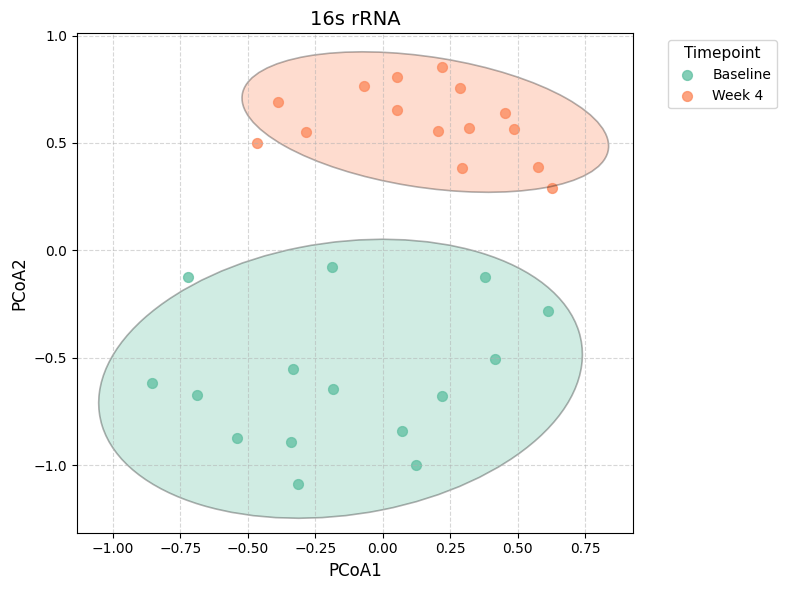

In [78]:
# Step 5: PCoA (using classical MDS)
pcoa = MDS(n_components=2, dissimilarity='precomputed', random_state=42)
pcoa_coords = pcoa.fit_transform(dist_matrix)  # dist_matrix: your precomputed distance matrix

# Create DataFrame for PCoA results
pcoa_df = pd.DataFrame(pcoa_coords, columns=["PCoA1", "PCoA2"], index=filtered_df.index)
pcoa_df['Sample_ID'] = pcoa_df.index  # optional if Sample_ID is part of index

# Merge with metadata
plot_df = pcoa_df.merge(filtered_df, left_index=True, right_index=True)

# Step 6: Plot and detect outliers
# Define custom group colors
colors = {
    'Baseline': '#66c2a5',
    'Week 4': '#fc8d62'
}

# Create plot
fig, ax = plt.subplots(figsize=(8, 6))

for group in plot_df["Timepoint"].unique():
    group_data = plot_df[plot_df["Timepoint"] == group]
    
    ax.scatter(
        group_data["PCoA1"], group_data["PCoA2"],
        label=group, s=50, alpha=0.8, color=colors.get(group, 'gray')
    )

    # Draw confidence ellipse for each group
    confidence_ellipse(
        group_data["PCoA1"].values,
        group_data["PCoA2"].values,
        ax,
        n_std=2.0,
        facecolor=colors.get(group, 'gray'),
        edgecolor='black',
        linewidth=1.2,
        alpha=0.3
    )

# Labels and styling
ax.set_title("16s rRNA", fontsize=14)
ax.set_xlabel("PCoA1", fontsize=12)
ax.set_ylabel("PCoA2", fontsize=12)
ax.tick_params(labelsize=10)
ax.legend(title="Timepoint", loc='upper left', bbox_to_anchor=(1.05, 1), fontsize=10, title_fontsize=11)
ax.grid(True, linestyle='--', alpha=0.5)

plt.tight_layout()
plt.savefig('PCoA_16srRNA.png', dpi=300)
plt.show()